In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

In [2]:
dff = pd.read_excel("Credit+Card+Customer+Data.xlsx")

In [3]:
dff

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0


In [4]:
# creating a copy of the original data to avoid tampering with the original data
df = dff.copy()

### Check information of the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


#### Observations
- This data has 660 rows and 7 columns, all columns has a datatye of integer

In [6]:
## checking for duplicate values
df.duplicated().sum()

0

In [7]:
# drop the SL_No column, i dont thing it is needed
df.drop("Sl_No", axis=1, inplace=True)

In [8]:
df.describe()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


- The min Total_visits_bank, Total_visits_online, Total_calls_made of some customers are 0, it means those customers did not either visit the bank at all throughout the year, login the bank onliine to either make transactions or complain online, or make some calls to the bank or its customer for the whole year. If any customer has all these there variables to be 0, i will suggest that cutomer account is dorman

- The minimum average credit limit of customers is 3000 while the maximum is 200000

In [9]:
# no customer has the 3 to be 0
df[(df["Total_visits_bank"] == 0) & (df["Total_visits_online"] == 0) & (df["Total_calls_made"] == 0)]

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


In [10]:

df[(df["Total_visits_bank"] == 0) & (df["Total_visits_online"] == 0)]

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


- No customer has both condition to be 0 also, if a cuatomer has just one condtion from eaither Total_visits_bank, Total_visits_online or Total_calls_made to be 0, it is very possible for the customer not have done any of these throughout the year.

In [11]:
df[(df["Total_visits_bank"] == 0)]

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
1,38414,50000,3,0,10,9
4,47437,100000,6,0,12,3
5,58634,20000,3,0,1,8
6,48370,100000,5,0,11,2
7,37376,15000,3,0,1,1
...,...,...,...,...,...,...
645,48762,171000,10,0,15,0
646,58392,186000,7,0,8,1
647,79953,183000,9,0,9,2
653,51826,95000,10,0,15,1


In [12]:
# check for missing values
df.isnull().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

## EDA

In [13]:
# import a custome made function
from utils import labeled_barplots, histogram_boxplot, custom_scatterplot

In [14]:
num_col = df.select_dtypes(include="number").columns.to_list()
num_col

['Customer Key',
 'Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

In [15]:
# labeled_barplots(df, feature=num_data, perc=True, title="Plot")

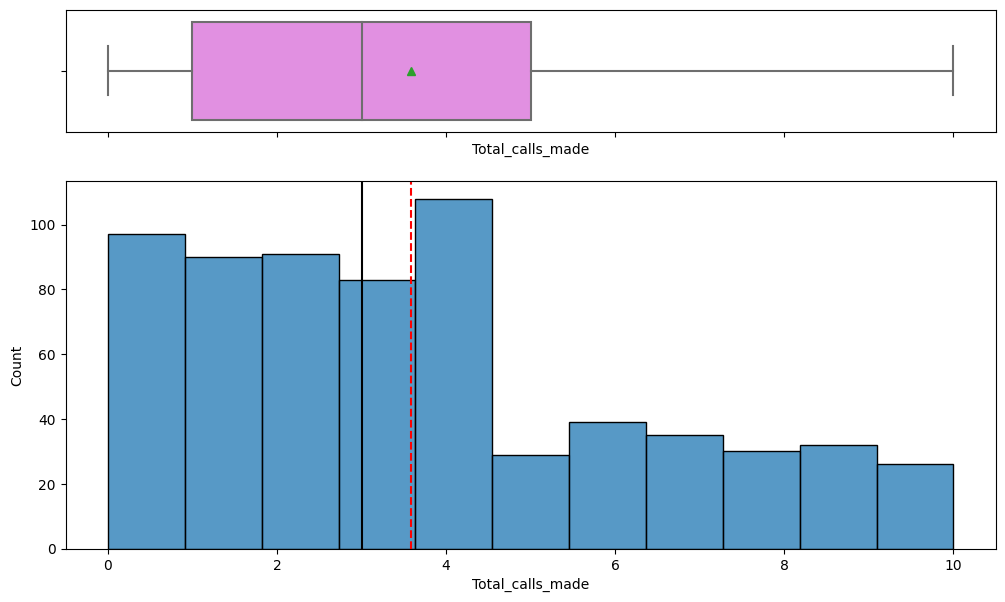

In [16]:
histogram_boxplot(df, "Total_calls_made")

- Very few cutomers make calls to the customer service for like about 4.5 to 10 times yearly
- A lot of customers make call to the bank around 0-4 times yearly

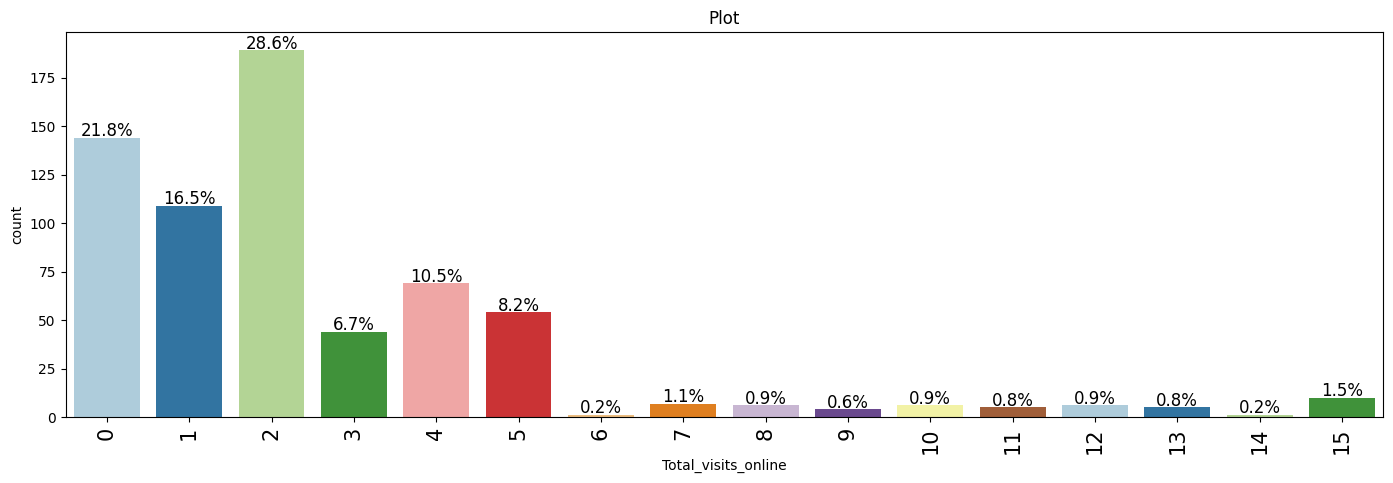

In [17]:
labeled_barplots(df, "Total_visits_online", perc=True, title="Plot")

#### Observation

- A lot of customers visit the bank or makde online logins yearly, which made it about 28.6% of the customers does that
- Followed by the customers that doesnt have any reason to the visit the bank online service at all, they occupy about 21.8%
- very few customers visit the bank online service 14 times yearly, just 0.2%

### Bivariate Analysis

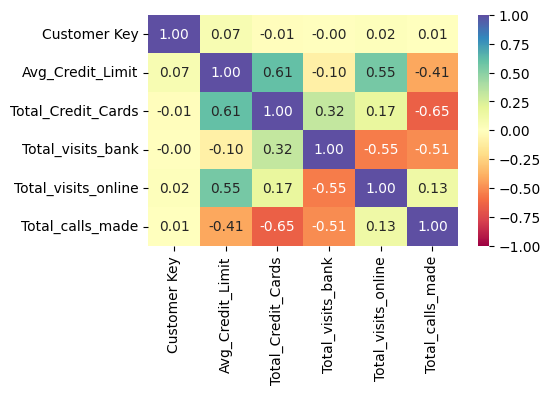

In [18]:
num_df = df[num_col]

cor = num_df.corr()

## plot the correlaition plt
plt.figure(figsize=(5,3))
sns.heatmap(cor, vmin=-1, vmax=1,cmap="Spectral", annot=True, fmt=".2f")
plt.show()

- This plot shows that there is a slightly strong positive correaltion between Average credit limit and total credit cards, that means when the average credit limit increases, the amount of credit card the customer tend to have also increases.
- Also there is a negative correlation between between total credit card and total calls made, that means as total credit cards increases, total calls made tends to decrease. This means there is an inverse relationship between the two variables.

In [19]:
# drop customer key and average credit limit
df.drop(["Customer Key", "Avg_Credit_Limit"], axis=1, inplace=True)

In [20]:
num_col = df.columns.to_list()
num_col

['Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

## K-Means Clustering

In [21]:
## instantiate scaler
scaler = StandardScaler()

#scale the data
scaled_df = scaler.fit_transform(df)

In [22]:
kmeans = KMeans(random_state=0)

kmeans.fit(scaled_df)

F:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=0)

In [23]:
# predict
y_pred = kmeans.predict(scaled_df)

In [24]:
# calculating the silhouette score
silhouette_score(scaled_df, y_pred)

0.26735236131976137

- By using the default number of clusters which is 8, it gives a poor silhouette score of 0.27 aproximately

#### Figure out appropriate number of clusters

In [25]:
clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(scaled_df)  # Fit kMeans on the data
    prediction = model.predict(scaled_df)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(scaled_df, model.cluster_centers_, "euclidean"), axis=1))
        / scaled_df.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

F:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
F:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
F:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
F:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 1 	Average Distortion: 1.8259548346750432
Number of Clusters: 2 	Average Distortion: 1.2738379735051664
Number of Clusters: 3 	Average Distortion: 1.0289227488774146
Number of Clusters: 4 	Average Distortion: 0.9143721125447829


F:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
F:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
F:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 5 	Average Distortion: 0.8588259931589542
Number of Clusters: 6 	Average Distortion: 0.8199311758225963
Number of Clusters: 7 	Average Distortion: 0.779298036022725
Number of Clusters: 8 	Average Distortion: 0.7547473673400034


F:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Ploting an elbow curve

Text(0.5, 1.0, 'Selecting number of clusters')

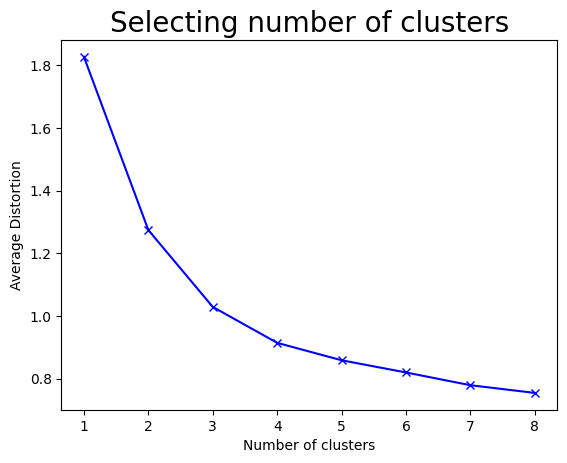

In [26]:
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("Number of clusters")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting number of clusters", fontsize=20)  # Title of the plot

- It forms an elbow curve at cluster 2 and 4, so i can use these clusters to perform my clsutering again 

In [27]:
## instantiate k-means
kmeans_2 = KMeans(n_clusters=2, random_state=0)

# fit the kmeans
kmeans_2.fit(scaled_df)

F:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

In [28]:
## perform the prediction
labels_2 = kmeans_2.predict(scaled_df)

In [29]:
# calculating the silhouette score
silt_score_2 = silhouette_score(scaled_df, labels_2)
silt_score_2

0.45388735049136736

#### Using 4 clusters

In [30]:
## instantiate k-means
kmeans_3 = KMeans(n_clusters=4, random_state=0)

# fit the kmeans
kmeans_3.fit(scaled_df)

F:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=0)

In [31]:
## perform the prediction
labels_3 = kmeans_3.predict(scaled_df)

# calculating the silhouette score
silt_score_3 = silhouette_score(scaled_df, labels_3)
silt_score_3

0.3868799639660076

- The score is low after icreasing the number of clusters to 4, 2 clusters still performs better

In [32]:
# kmeans_2.labels_

In [33]:
# adding kmeans cluster labels to the original dataframe
df["Kmeans_clusters"] = kmeans_2.labels_

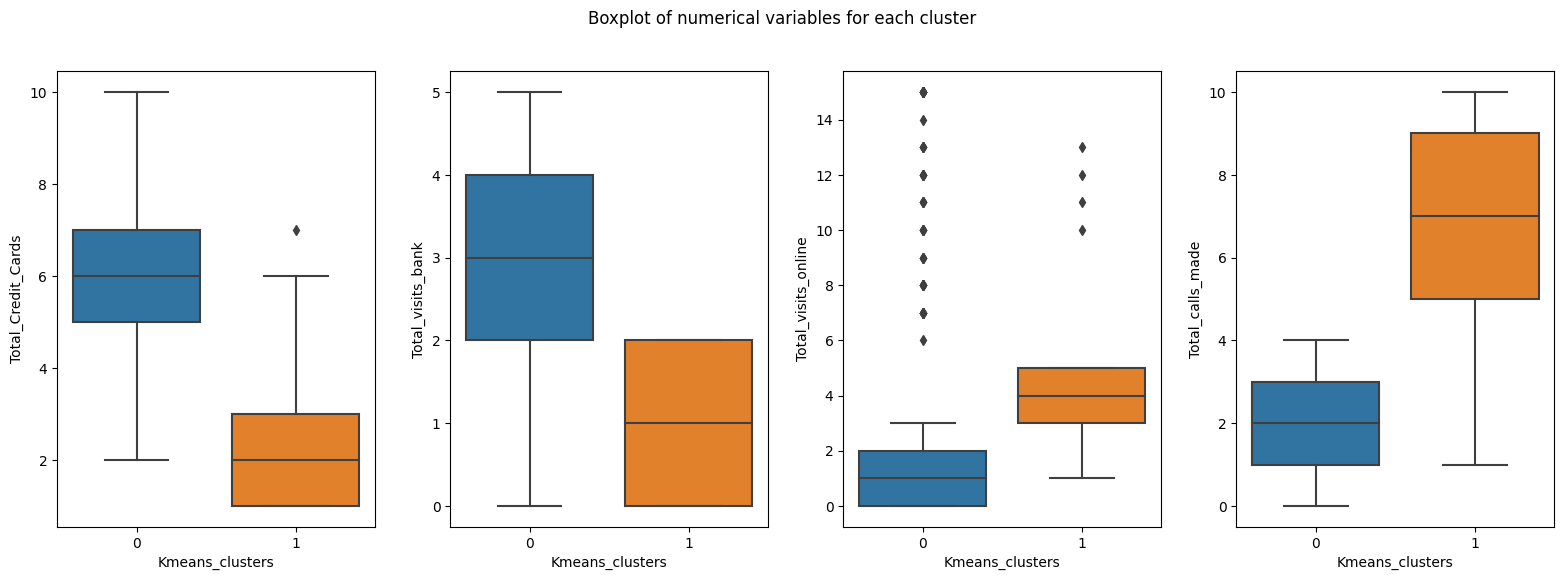

In [34]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["Kmeans_clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<Axes: xlabel='Kmeans_clusters'>

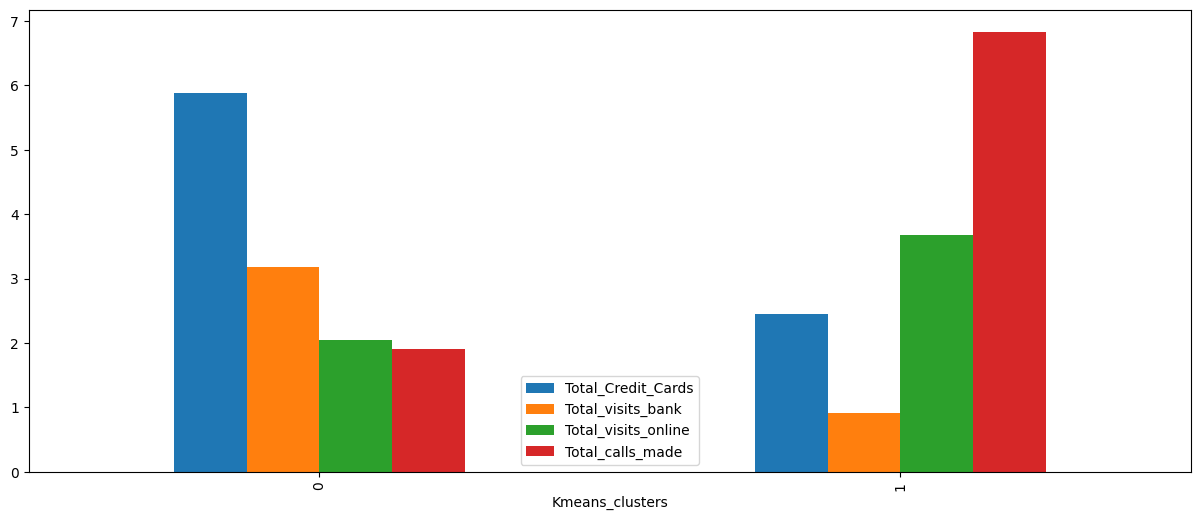

In [35]:
df.groupby("Kmeans_clusters").mean().plot.bar(figsize=(15, 6))

#### Observation
##### Cluster 0
- Total credit card is high
- Total visit to bank is high
- Total visit online is low
- Total calls made is like low to moderate

##### Cluster 1
- Total credit card is from low to moderate
- Total visit to bank is also low
- Total visit online is also moderate, although have some outliers
- Total calls made is high, i.e the customers in this clsuter make calls alot to the customer care

### Recommendation

- If the bank want to forcus on customers that spend alot, i think they should pick the customers on cluster 0 and focus their advert more on them, because they have alot of credit cards, they visit the bank frequently, probably to make transactions, because those customoers tent not to make calls to the make calls to the customer service, because my thinking will be those customers that calls the customer care alot do that to complain, which this customers in cluster 0 dont do.

- If they want to fit their customer service glitch and focus more on customer satisfaction, they should focus more on the customers in clusters 1, becasue the tend to call the customer service alot, and they posses fewer credit card to moderate.

### Applying DBSCAN

In [36]:
# create an instance of dbscan
dbscan = DBSCAN()

db_labels = dbscan.fit_predict(scaled_df)

In [37]:
# chceck the unique values
np.unique(db_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

- We have 10  unique groups including the outliers which is -1

In [40]:
import itertools

In [51]:
# Trying values of eps between 0.1 and 1; minPts between 2 and 10
eps = np.linspace(0.1, 1, 10)
minPts = np.arange(2, 5)

In [50]:
np.arange(2, 10)

array([2, 3, 4, 5, 6, 7, 8, 9])

In [52]:
# Create a tuple of eps and minPts using product method of itertools
hyper_list = list(itertools.product(eps, minPts))

# run a loop to pick the eps ans minPts from the tuple
for (eps, minPts) in hyper_list:
    dbscan = DBSCAN(eps=eps, min_samples=minPts)
    labels = dbscan.fit_predict(scaled_df)
    score = silhouette_score(scaled_df, labels)
    print(f"eps : {eps}; MinSamples : {minPts}; num_labels : {len(np.unique(labels))}; Score : {score}")

eps : 0.1; MinSamples : 2; num_labels : 165; Score : 0.35046433012734146
eps : 0.1; MinSamples : 3; num_labels : 67; Score : -0.11551399421245681
eps : 0.1; MinSamples : 4; num_labels : 21; Score : -0.3657549420024192
eps : 0.2; MinSamples : 2; num_labels : 165; Score : 0.35046433012734146
eps : 0.2; MinSamples : 3; num_labels : 67; Score : -0.11551399421245681
eps : 0.2; MinSamples : 4; num_labels : 21; Score : -0.3657549420024192
eps : 0.30000000000000004; MinSamples : 2; num_labels : 165; Score : 0.35046433012734146
eps : 0.30000000000000004; MinSamples : 3; num_labels : 67; Score : -0.11551399421245681
eps : 0.30000000000000004; MinSamples : 4; num_labels : 21; Score : -0.3657549420024192
eps : 0.4; MinSamples : 2; num_labels : 61; Score : 0.11854135170839347
eps : 0.4; MinSamples : 3; num_labels : 50; Score : 0.08488121292819892
eps : 0.4; MinSamples : 4; num_labels : 42; Score : 0.0553585587237973
eps : 0.5; MinSamples : 2; num_labels : 23; Score : -0.009192620993750596
eps : 0.5

### Re-building the model with min samples of 4, eps of 1.0, and number of label 3

In [82]:
# iinstantiate DBSCAN model
dbscan_2 = DBSCAN(eps=1.0, min_samples=8)

label_2 = dbscan_2.fit_predict(scaled_df)

# calculate the score
score_2 = silhouette_score(scaled_df, label_2)

In [83]:
score_2

0.4399549018480101

- Icreasing the min ssamples to 8 performs better with a score of 0.44 approximately, as compare to using just 4 min_samples which gives a silhouette score of 0.39. 

In [91]:
dbscan_df = num_df
dbscan_df.drop(["Customer Key", "Avg_Credit_Limit"], axis=1, inplace=True)

### Visualization

In [93]:
# adding kmeans cluster labels to the original dataframe
dbscan_df["DBScan_clusters"] = dbscan_2.labels_

In [97]:
dbscan_num_col = dbscan_df.columns.to_list()

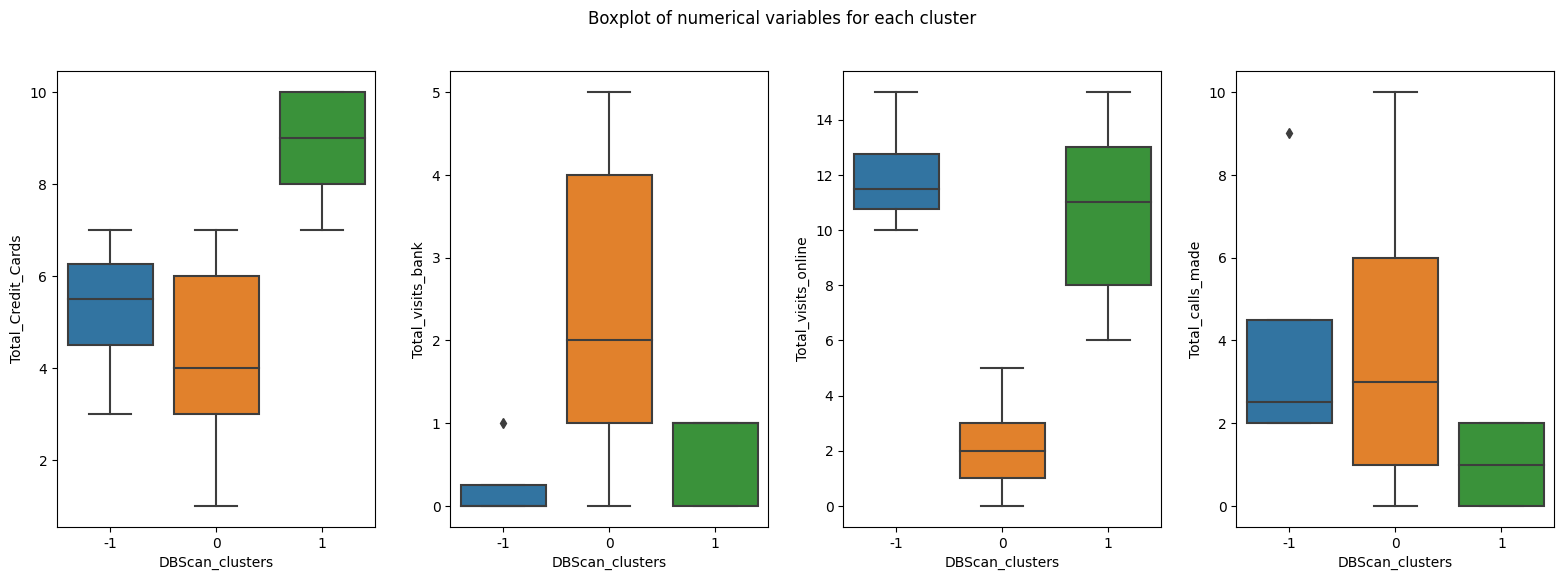

In [99]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii], y=dbscan_df[dbscan_num_col[counter]], x=dbscan_df["DBScan_clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<Axes: xlabel='DBScan_clusters'>

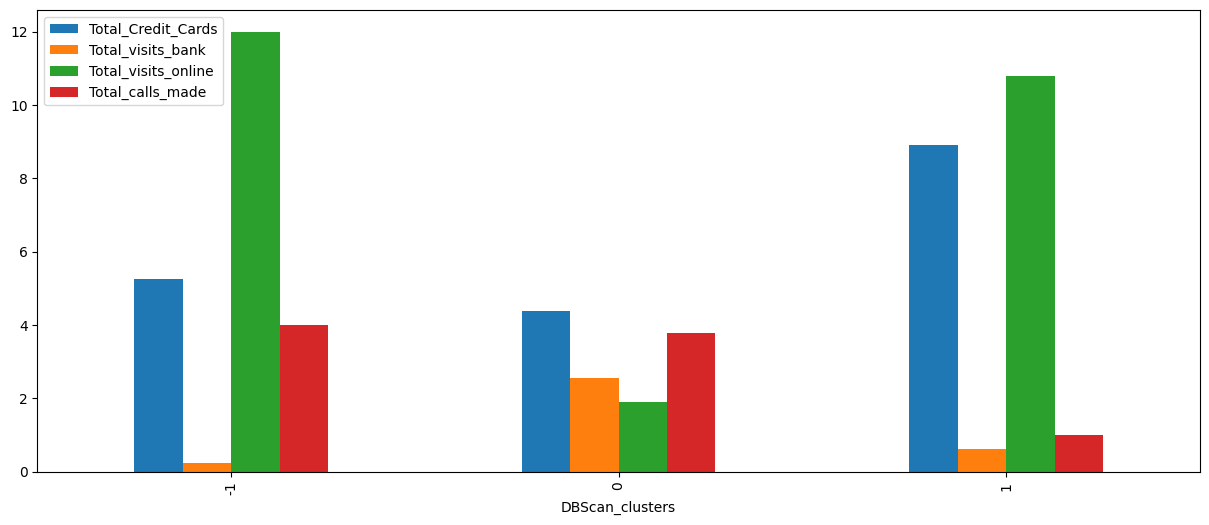

In [100]:
dbscan_df.groupby("DBScan_clusters").mean().plot.bar(figsize=(15, 6))

- Dbscan grouped the noise (outliers) in -1 group, the customers in group 0 dont make too much of calls to cuatomer care, dont visit online regularly, they dont visit the bank ofter either, but some have 4 or more credit cards.
- The customers in cluster 1 have alot of credit cards, visit oline freequently but dont visit bank and dont make calls to the customer service, maybe these category of customers are the ones whow prefer to do their things online.